QISHA_GenROIS
Created by JFranco, 14 AUG 2023

This Python notebook reads in a seed image and uses Cellpose to segment the image into ROIs. It generates a map of the ROIs and saves the relevent info for use in Image J. The code is based on code written by JFranco (Github repository CaTA). 

In [28]:
#                           *** LIBRARIES ***
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
from cellpose import models , plot
import imageio
import pandas as pd
#import glob
#from scipy.ndimage import gaussian_filter
#from scipy import stats
#from skimage import io
from cellpose import io, utils

In [29]:
#                   *** WHERE TO GET/SAVE DATA ***   
# Directories 
#   UPDATE THIS INFO TO REFLECT YOUR SYSTEM
dirMain = "/Users/joyfranco/Dropbox (Partners HealthCare)/JF_Shared/Data/CYS/CYS_003/"
dirSI = dirMain+'SeedImages/'

#   ones that need to be made
dirROIs = dirMain+'ROIs/'
dirMasks = dirMain+"Masks/"                                                     # For storing cellpose masks 
dirMAs = dirMain+"MaskAreas/"
dirMLs = dirMain+"MasksLabeled/"

# Create directory for storing ROIs and Masks
if not os.path.exists(dirROIs):
    os.mkdir(dirROIs)
    os.mkdir(dirMasks)
    os.mkdir(dirMAs)
    os.mkdir(dirMLs)

In [32]:
#                   *** GET LIST OF SEED IMAGES ***   
# Go to the location of the seed images and get a list
os.chdir(dirSI)
ims = os.listdir()

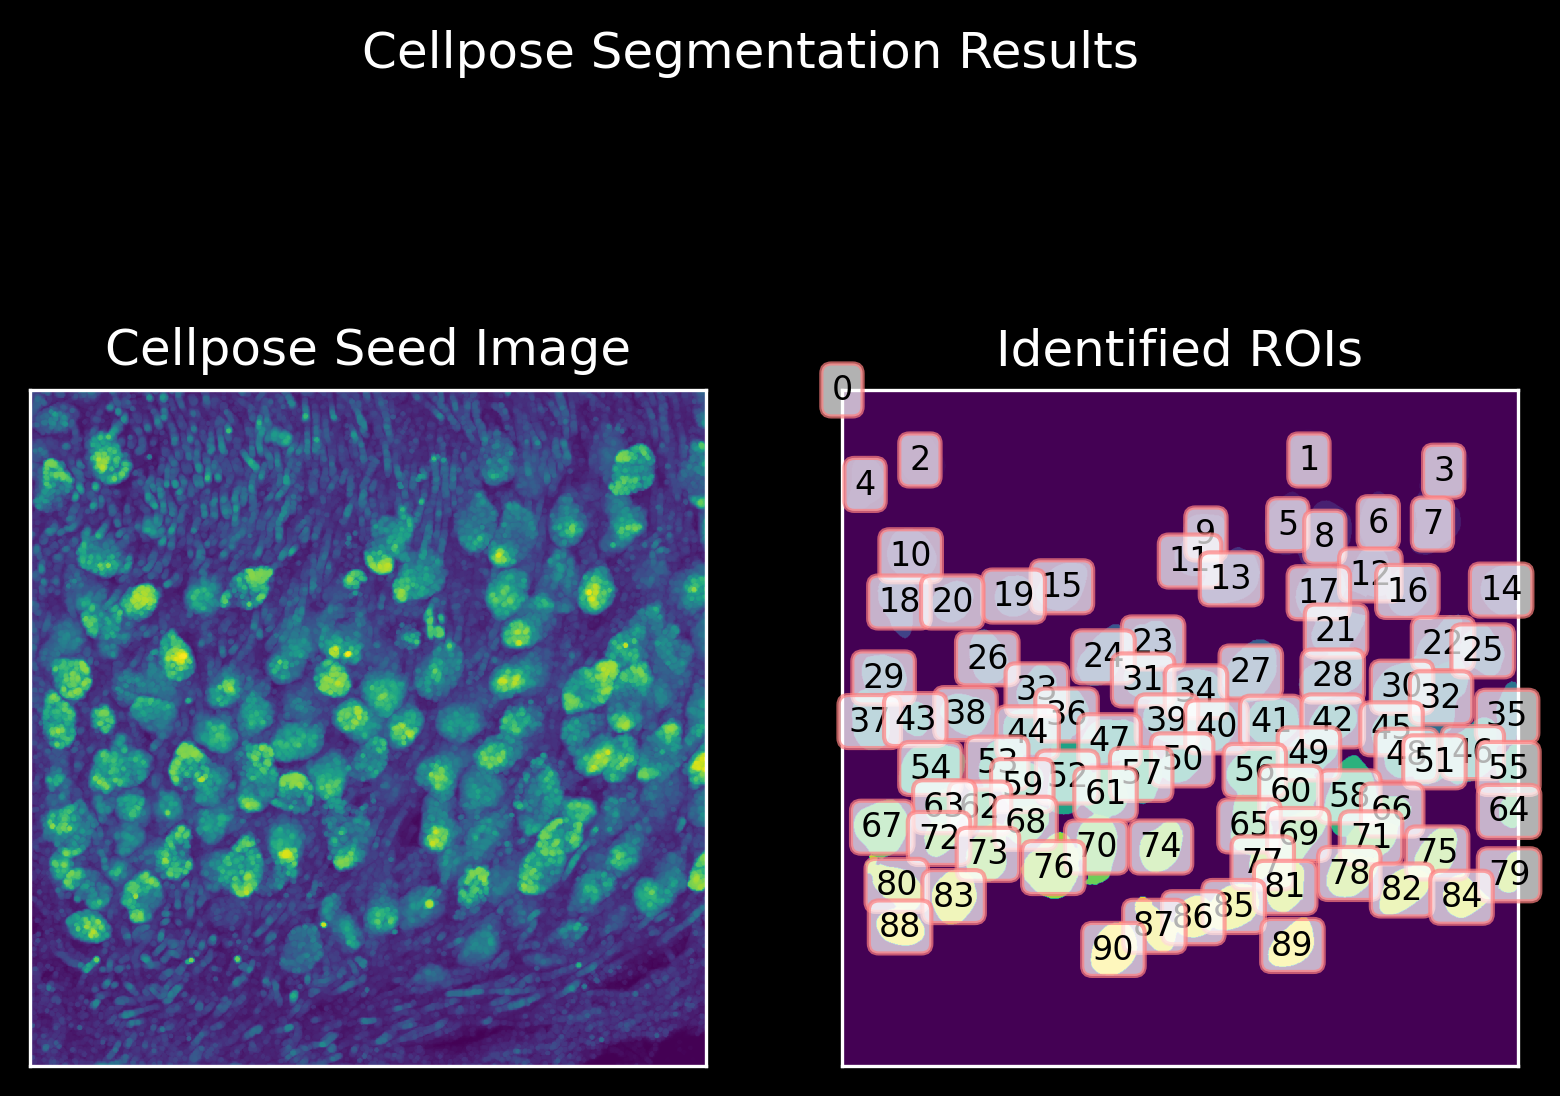

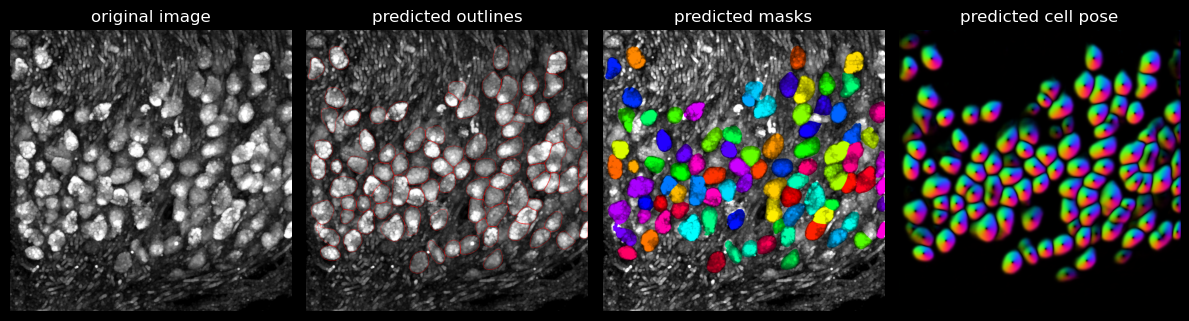

In [33]:
#                   *** BEGIN SEGMENTATION ***   
# Iterate through the seed images and process with Cellpose
for im in ims:
    if "SeedImage.png" in im:
        # Get the filename base
        fnBase = im.split(".SeedImage",1)[0]
        
        # Files to make
        fnMskCSV = fnBase+'.Masks.csv'
        fnMskArea = fnBase+'.MaskAreas.csv'
        fnMskLab = fnBase+'.MasksLabeled.png'
        fnCP = fnBase+'Cellpose.png'
        
        # Initialize dataframe for storing mask areas
        dfAreas = pd.DataFrame()
        
        #                *** GENERATE ROI MASK FROM SEED IMAGE **
        # Create cell pose model
        #   model_type='cyto' or model_type='nuclei'
        model = models.Cellpose(gpu=False, model_type='cyto')
        chan=[0,0]
        #   read in the seed image 
        img = io.imread(dirSI+im)
        #   generate the masks using the seed image as the input for the model 
        masks, flows, styles, diams = model.eval(img, diameter=100, channels=chan,
                                                 invert=False)
        #   create a dataframe based on the masks and save to csv
        pd.DataFrame(masks).to_csv(dirMasks+fnMskCSV)                                  
        
        #               *** USE MASKS TO GET MEAN GREY ***
        # Arrays for storing median xs ys of mask labels 
        labels = np.array([0,0,0])
        labels = labels.reshape(1,3)
        
        # Iterate over unique rois in the mask
        for roi in np.unique(masks):
            
            if roi != 0:  # skip background
                
                # setup the roiID to extend off prep+sample
                roiID = fnBase+'.'+str(roi)
                
                # get y & x coords of the roi
                ys, xs = np.nonzero(masks == roi)
                
                # need to store the median ys and xs for labeling rois
                x = [float(roi),np.median(xs),np.median(ys)]        
                x = np.array(x)
                labels = np.concatenate((labels,x.reshape((1,3))),axis=0)     
                
                # GET ROI AREA AND ADD TO DF
                df = pd.DataFrame([[roiID,len(xs)]],columns=['roiID','area_sqpix'])
                dfAreas = pd.concat([dfAreas,df])
        
        #       *** WRITE ALL MEASURED VALUES TO FILE ***
        dfAreas.to_csv(dirMAs+fnMskArea)
        
        #       *** CREATE MASK IMAGE WITH LABELS ***        
        
        fig, axes = plt.subplots(1, 2, dpi=300)
        fig.suptitle('Cellpose Segmentation Results')
        #plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.5, wspace=0.4)
        plt.style.use('dark_background')
        
        # Plot #1: the seed for cellpose
        ax2 = plt.subplot(121)       
        ax2.set_title('Cellpose Seed Image')
        ax2.set_xticks([])
        ax2.set_yticks([])
        #box = ax2.get_position()
        #box.y0 = box.y0 - 0.1
        #box.y1 = box.y1 - 0.1
        #ax2.set_position(box)
        ax2.set_xlabel('')
        ax2.set_ylabel('')          
        plt.imshow(img, interpolation='nearest')                              #subplot(nrows, ncols, index, **kwargs)
        
        # Labeled image
        ax1 = plt.subplot(122)
        ax1.set_title('Identified ROIs')
        ax1.set_xticks([])
        ax1.set_yticks([])
        #box = ax1.get_position()
        #box.y0 = box.y0 - 0.1
        #box.y1 = box.y1 - 0.1
        #ax1.set_position(box)
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        plt.imshow(masks)
        for i in range(0,len(labels)):
            plt.text(labels[i][1], labels[i][2], str(round(labels[i][0])),
                     ha="center", va="center", size=8,
                     bbox=dict(boxstyle="round",
                               ec=(1., 0.5, 0.5),
                               fc='w',
                               #fc=(1., 0.8, 0.8),
                               alpha=0.7
                               ), 
                     color ='black')                                                  #subplot(nrows, ncols, index, **kwargs)
        
        plt.savefig(dirMLs+fnMskLab, dpi='figure', format="png", metadata=None,
                bbox_inches=None, pad_inches=0.1,
                facecolor='auto', edgecolor='auto',
                backend=None)
        
        # Save summary image of masks and show to user
        fig = plt.figure(figsize=(12,5))
        plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
        plt.tight_layout()
        plt.savefig(dirMLs+fnCP, dpi='figure', format="png", metadata=None,
                bbox_inches=None, pad_inches=0.05,
                facecolor='auto', edgecolor='auto',
                backend=None)

# Export the masks as an ROI archive file for ImageJ
# the file will be saved as '<your_filename_string>_rois.zip'
#io.save_rois(masks, dirROIs+fnBase)